# 1. Import packages and Global parameters setting

In [1]:
import jax.numpy as jnp
from jax import grad as fgrad
from jax import jit, vmap, jacfwd, jacrev
import numpy as np
from numpy.linalg import norm
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.autograd import grad
from scipy.integrate import solve_ivp
np.set_printoptions(suppress=True)
from matplotlib import pyplot as plt

from copy import deepcopy

ITERATIONS = 10
CUDA = torch.cuda.is_available()
mse = nn.MSELoss(reduction='none')
NBATCH = 512
NUMERICAL_METHOD = 'RK45'

In [2]:
import cvxpy as cp
import numpy as np
import time

# Define the problem parameters
C = np.array([
    [1, 4, 2, 2, 1.3, 4, 2, 1],
    [2.8, 2, 1.6, 3.2, 0, 2, 1, 1],
    [1, 4, 2.3, 2, 2.5, 0, 5, 1],
    [1, 1, 1, 3.1, 2.3, 0, 0.8, 1]
])

d = np.array([1.5, -3.8, 6.2, 7.5])

# Define the optimization variable
x = cp.Variable(8)

# Define the objective function
objective = cp.Minimize(cp.norm(C @ x - d, 1))

# Define the constraints
constraints = [
    x[0]**2 - x[1] + x[2] + x[4] - x[7] - 10 <= 0,
    cp.abs(x[0] - x[2] + x[3] + x[6]) - 4.8 <= 0,
    x[0] + x[2] + x[4] + x[6] - 1 == 0
]

# Define the problem
problem = cp.Problem(objective, constraints)

t0 = time.time()
result = problem.solve(solver=cp.SCS)
print('time: ' + str(time.time()-t0))
print(problem.value)
print(x.value)

time: 0.046838998794555664
1.1438343605618684e-09
[ -0.00045844   4.28986017  -0.8787211    1.9393509    4.69662778
  -1.94500193  -2.81744825 -10.47095373]


# 2. The 5th NCP

In [3]:
# Qin, 2014 TNNLS, example 1
nx = 8
nu = 2
NY = nx+nu

xu0 = jnp.array([0.1 for i in range(NY)])
A = jnp.array([[1., 0., 1., 0., 1., 0., 1., 0.]])
b = jnp.array([1.])
PM = A.T@jnp.linalg.inv(A@A.T)@A

def f(x):
    output = jnp.linalg.norm(C@x-d, 1)
    return output

def g(x):
    g1 = x[0]**2 - x[1] + x[2] + x[4] - x[7] - 10
    g2 = jnp.abs(x[0] - x[2] + x[3] + x[6]) - 4.8
    output = jnp.array([g1, g2])
    return output

def h(x):
    output = jnp.clip(A@x-b, a_min=-1, a_max=1)

    return output

df = fgrad(f) # jacobian of f
dg = jacrev(g) # jacobian of g

def P(xu): # projection mapping
    x, u = xu[:nx].reshape((nx,)), xu[nx:].reshape((nu,))
    x = x - (A.T@jnp.linalg.inv(A@A.T))@((A@x-b).reshape((-1, )))
    u = np.clip(u, a_min=0, a_max=None)
    output = np.concatenate([x, u], axis=0)
    return output

In [4]:
def ODE(t, xu):
    x, u = xu[:nx].reshape((nx, )), xu[nx:].reshape((nu, ))

    dx = df(x) + dg(x).T@jnp.clip(u+g(x), a_min=0)
    dx = -(jnp.identity(nx) - PM)@dx - A.T@h(x)
    du = -u + jnp.clip(u+g(x), a_min=0)
    du = 0.5*du
    dxu = jnp.concatenate([dx, du], axis=0)
    return dxu

ODE = jit(ODE)

def evalutation(xu): # metric OuC(x_pred): check if inisde feasable region and return the objective value
    "return  f(x),    if g(x)<=0, \
        f(x)=np.inf, if g(x)>0 "
    x, u= xu[:nx], xu[nx:]
    if (g(x)<=0).all():
        obj = f(x)
    else:
        obj = np.inf
    return obj


In [5]:

#sol = solve_ivp(ODE, [0., 10.], xu0, t_eval=np.arange(0, 10, 0.1), method='BDF')

In [6]:
"""
result = P(sol.y[:, -1])
print(evalutation(result))
print(result)
"""

'\nresult = P(sol.y[:, -1])\nprint(evalutation(result))\nprint(result)\n'

In [7]:
"""
x, u = result[:nx], result[nx:]
error1 = df(x)+u@dg(x)
error1 = np.max(np.abs((error1)))
error2 = u-np.clip(u+g(x),a_min=0,a_max=None)
error2 = np.max(np.abs((error2)))
print(error1, error2)
"""

'\nx, u = result[:nx], result[nx:]\nerror1 = df(x)+u@dg(x)\nerror1 = np.max(np.abs((error1)))\nerror2 = u-np.clip(u+g(x),a_min=0,a_max=None)\nerror2 = np.max(np.abs((error2)))\nprint(error1, error2)\n'

# 3. The method

In [8]:
class FNN(nn.Module):
    def __init__(self, y0):
        self.y0 = torch.tensor(y0, dtype=torch.float)
        if CUDA:
            self.y0 = self.y0.cuda()
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(1, NEURONS).cuda()
        self.linearL = []
        for _ in range(LAYERS-1):
            self.linearL.append(nn.Linear(NEURONS, NEURONS).cuda())
        self.linear2 = nn.Linear(NEURONS, NY).cuda()

    def forward(self, x):
        t = x.cuda()
        x = torch.tanh(self.linear1(x))
        for i in range(LAYERS-1):
            x = torch.tanh(self.linearL[i](x))
        x = self.linear2(x)
        x = self.y0 + (1 - torch.exp(-(t-0)))*x
        return x

class NN_NOP:
    def __init__(self, y0, time_range, P, ODE, C_epsilon): # P: projection mapping, ODE, C_epsilon: OuC metric
        self.y0 = np.array(y0)
        self.time_range = time_range # [0, 10]
        self.T = time_range[-1] # T=10
        self.P = P
        self.ODE = ODE
        self.C_epsilon = C_epsilon
        self.vODE = vmap(ODE)
        #self.numerical_method() # solve analyicallly the ODE

    def numerical_method(self):
        sol = solve_ivp(self.ODE, self.time_range, self.y0, method=NUMERICAL_METHOD)
        self.y_T_ODE = sol.y[:, -1] # get last value of the solution
        self.y_T_ODE = self.P(self.y_T_ODE) # project it
        self.y_T_ODE = np.array(self.y_T_ODE)
        self.epsilon_ODE = self.C_epsilon(self.y_T_ODE) # calculate OuC (f(x))

    def NN_method(self):
        """
        train the nn, store the following four

        L_loss:  list, loss of batch during training
        L_epsilon: list, epsilon_best during training
        L_y_T: list, yT during training
        net_best:  the best neural network model during training
        """
        net = FNN(self.y0)
        if CUDA:
            net = net.cuda()

        optimizer = Adam(net.parameters(), lr=LR)
        i = 0
        L_loss = []
        L_epsilon = []
        L_epsilon_curr = []
        L_y_T = []
        L_y_T_curr = []
        L_y_iterations = []
        while True:
            # Update, L_epsilon, L_yT, net_best
            T = self.T*torch.ones((1, 1), dtype=torch.float)
            if CUDA:
                T = T.cuda()
            y_T = self.P_multiple(T, net) # get the output of the nn at T (last time)
            L_y_T_curr.append(y_T)

            epsilon_current = self.C_epsilon(y_T) # calculate OuC (f(x))
            L_epsilon_curr.append(epsilon_current)
            if i==0: # if first iteration
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
                L_y_iterations.append(self.y_iteration(net_best))
            # if i==10:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==20:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==ITERATIONS-1:
            L_y_iterations.append(self.y_iteration(net_best)) # store the output of the best nn across the time
            if epsilon_current < epsilon_best:
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
            L_epsilon.append(epsilon_best) # store the best OuC
            L_y_T.append(y_T_best) # store the best output of the nn at T

            # TRAIN MODEL
            # Prepare input t, torch.tensor (NBATCH, 1)
            t = np.random.uniform(0, self.T, (NBATCH, 1))
            t = torch.tensor(t, dtype=torch.float, requires_grad=True)
            if CUDA:
                t = t.cuda()

            # Learning, L_loss
            loss = self.loss_compute(t, net)
            loss.backward()
            L_loss.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()

            # Monitor
            if i%100==0:
            # if i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                #print(f'T: {self.T}, y_T_ODE: {self.y_T_ODE.round(4)}, epsilon_ODE: {self.epsilon_ODE :.4f},  Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}, ||y_T_ODE-y_T_best||_2: {y_T_error :.4f}')
                print(f'T: {self.T}, Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}')
            i = i+1
            if i==ITERATIONS:
                break

        return L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_y_iterations, L_loss

    def loss_compute(self, t, net, weighting=0.5):
        # nn output xu, torch.tensor (NBATCH, nxu)
        y = net(t)

        # => Get ODE derivatives
        # True dxu, torch.tensor (NBATCH, nxu)
        dy = self.vODE(t.cpu().detach().numpy(), y[:, :].cpu().detach().numpy())
        dy = np.array(dy)
        dy = torch.tensor(dy, dtype=torch.float)
        if CUDA:
            dy = dy.cuda()

        # => Get NN derivatives (autograd)
        # Predicted pdxu, torch.tensor (NBATCH, nxu)
        pdy = []
        for j in range(NY): # for all outputs node (for all variables)
            # y[:, [j]]: outputs of the nn for the j-th variable (all t of the batch), t: inputs of the nn, grad_outputs: scale the gradients to facilitate the compuation of the jacobian, Craete_graph: to compute higer order derivatives
            pdyi = grad(y[:, [j]], t, grad_outputs=torch.ones_like(y[:, [j]]), create_graph=True)[0] # torch autograd shape [NBATCH, 1]
            pdy.append(pdyi)
        pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]

        # Compute loss, torch.tensor a float
        loss = mse(dy, pdy) # [NBATCH, NY]
        loss = torch.sum(loss, axis=1) # [NBATCH]
        if weighting is not None:
            loss = torch.exp(-weighting*t.detach().reshape((-1, )))*loss # proprity smaller t
        loss = torch.mean(loss, axis=0)
        return loss

    def P_multiple(self, t, net): # get the projection of the output of the nn (for multiple t)
        y = net(t)
        y = y.reshape((-1, )).cpu().detach().numpy()
        output = self.P(y)
        output = np.array(output)
        return output

    def y_iteration(self, net): # get the ODE system estiamtion across the time
        # For L_y
        t = torch.arange(0, self.T, 0.1).reshape((-1, 1))
        if CUDA:
            t = t.cuda()
        y = [self.P_multiple(t[i].reshape((1,1)), net) for i in range(t.shape[0])]
        y = torch.tensor(np.array(y)).cpu().detach().numpy()

        return y # [T, NY]


In [9]:
NBATCH = 128
ITERATIONS = 1000
LR = 0.01
NEURONS = 500
LAYERS = 2
y0 = np.array([1. for _ in range(NY)])

In [10]:
LAYERS = 1

example_N100 = NN_NOP(y0, [0, 10], P, ODE, evalutation) # init
L_epsilon_N100, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_y_iterations, L_loss = example_N100.NN_method() # train

T: 10, Iteration: 0, Loss: 73.6388,  epsilon_best: 36.3551, y_T: [-0.2793  1.6964  0.5099  1.3976  0.6144  0.7335  0.155   0.8222  0.5804
  1.8782]
T: 10, Iteration: 100, Loss: 45.4097,  epsilon_best: 7.7298, y_T: [-1.4686  1.4083  0.1258 -0.1785  2.3981 -1.8911 -0.0553  1.052   0.2717
  0.6016]
T: 10, Iteration: 200, Loss: 22.7220,  epsilon_best: 3.7123, y_T: [-0.3293  0.6967 -1.1392  0.2071  3.0999 -0.4982 -0.6314  0.5656  0.0876
  0.047 ]
T: 10, Iteration: 300, Loss: 54.4347,  epsilon_best: 3.3713, y_T: [-1.7238  0.6552  0.494   0.6246  2.9018 -1.4766 -0.672   0.3748  0.0161
  0.0091]
T: 10, Iteration: 400, Loss: 24.5329,  epsilon_best: 3.3713, y_T: [-1.7238  0.6552  0.494   0.6246  2.9018 -1.4766 -0.672   0.3748  0.0161
  0.0091]
T: 10, Iteration: 500, Loss: 14.2906,  epsilon_best: 3.3713, y_T: [-1.7238  0.6552  0.494   0.6246  2.9018 -1.4766 -0.672   0.3748  0.0161
  0.0091]
T: 10, Iteration: 600, Loss: 50.6257,  epsilon_best: 3.3713, y_T: [-1.7238  0.6552  0.494   0.6246  2.9018 

In [11]:
LAYERS = 2

example_N300 = NN_NOP(y0, [0, 10], P, ODE, evalutation) # init
L_epsilon_N300, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_y_iterations, L_loss = example_N300.NN_method() # train

T: 10, Iteration: 0, Loss: 52.9509,  epsilon_best: 25.4074, y_T: [ 0.232   0.5191  0.4043  0.4484 -0.1067  1.0885  0.4703  1.3385  0.8214
  0.6401]


T: 10, Iteration: 100, Loss: 32.7864,  epsilon_best: 3.0662, y_T: [-0.8878  0.7821 -0.3997  0.1228  2.9516 -0.5898 -0.664   0.4588  0.
  0.6637]
T: 10, Iteration: 200, Loss: 21.4983,  epsilon_best: 3.0662, y_T: [-0.8878  0.7821 -0.3997  0.1228  2.9516 -0.5898 -0.664   0.4588  0.
  0.6637]
T: 10, Iteration: 300, Loss: 35.7987,  epsilon_best: 2.9804, y_T: [-1.117   0.3253 -0.8612  0.5999  3.1837 -1.0882 -0.2055  0.3956  0.0153
  0.    ]
T: 10, Iteration: 400, Loss: 31.5354,  epsilon_best: 1.6018, y_T: [-1.5075  0.2449 -0.199   0.5181  2.8825 -0.6659 -0.176   0.6085  0.0203
  0.0002]
T: 10, Iteration: 500, Loss: 21.3579,  epsilon_best: 1.6018, y_T: [-1.5075  0.2449 -0.199   0.5181  2.8825 -0.6659 -0.176   0.6085  0.0203
  0.0002]
T: 10, Iteration: 600, Loss: 50.6191,  epsilon_best: 1.6018, y_T: [-1.5075  0.2449 -0.199   0.5181  2.8825 -0.6659 -0.176   0.6085  0.0203
  0.0002]
T: 10, Iteration: 700, Loss: 27.0672,  epsilon_best: 1.6018, y_T: [-1.5075  0.2449 -0.199   0.5181  2.8825 -0.6659

In [12]:
LAYERS = 3

example_N500 = NN_NOP(y0, [0, 10], P, ODE, evalutation) # init
L_epsilon_N500, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_y_iterations, L_loss = example_N500.NN_method() # train

T: 10, Iteration: 0, Loss: 50.9568,  epsilon_best: 27.5989, y_T: [0.2672 0.9671 0.2155 0.7126 0.2187 0.9369 0.2986 1.1012 1.0004 1.0277]


T: 10, Iteration: 100, Loss: 31.9887,  epsilon_best: 3.8744, y_T: [-1.1665  0.289  -0.5907  0.5268  3.3788 -1.0152 -0.6216  0.2956  0.
  0.6015]
T: 10, Iteration: 200, Loss: 45.6093,  epsilon_best: 1.8717, y_T: [-1.5094  0.2097 -0.1755  0.3127  2.8604 -0.6169 -0.1754  0.5067  0.0743
  0.0472]
T: 10, Iteration: 300, Loss: 47.9205,  epsilon_best: 1.8717, y_T: [-1.5094  0.2097 -0.1755  0.3127  2.8604 -0.6169 -0.1754  0.5067  0.0743
  0.0472]
T: 10, Iteration: 400, Loss: 47.7559,  epsilon_best: 1.5543, y_T: [-1.8958 -0.2557 -0.1891  0.3456  3.0583 -0.2032  0.0267  0.9747  0.0166
  0.    ]
T: 10, Iteration: 500, Loss: 47.4591,  epsilon_best: 1.5543, y_T: [-1.8958 -0.2557 -0.1891  0.3456  3.0583 -0.2032  0.0267  0.9747  0.0166
  0.    ]
T: 10, Iteration: 600, Loss: 43.5852,  epsilon_best: 1.5543, y_T: [-1.8958 -0.2557 -0.1891  0.3456  3.0583 -0.2032  0.0267  0.9747  0.0166
  0.    ]
T: 10, Iteration: 700, Loss: 45.4503,  epsilon_best: 1.1332, y_T: [-1.74   -0.2429  0.2132  0.6388  2.6489 -0.

In [13]:
LAYERS = 4

example_N700 = NN_NOP(y0, [0, 10], P, ODE, evalutation) # init
L_epsilon_N700, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_y_iterations, L_loss = example_N700.NN_method() # train

T: 10, Iteration: 0, Loss: 50.0323,  epsilon_best: 30.3030, y_T: [0.1081 1.0327 0.3395 0.998  0.2287 1.1165 0.3237 0.9347 0.8924 1.0302]


T: 10, Iteration: 100, Loss: 44.0196,  epsilon_best: 1.7660, y_T: [-1.6941  0.213  -0.282   0.4893  2.9699 -0.7039  0.0061  0.7809  0.0714
  0.0193]
T: 10, Iteration: 200, Loss: 42.4275,  epsilon_best: 1.7660, y_T: [-1.6941  0.213  -0.282   0.4893  2.9699 -0.7039  0.0061  0.7809  0.0714
  0.0193]
T: 10, Iteration: 300, Loss: 29.5932,  epsilon_best: 1.5643, y_T: [-1.7848 -0.0499  0.0654  0.5378  2.8387 -0.4292 -0.1193  0.9235  0.0433
  0.0479]
T: 10, Iteration: 400, Loss: 29.2919,  epsilon_best: 1.5643, y_T: [-1.7848 -0.0499  0.0654  0.5378  2.8387 -0.4292 -0.1193  0.9235  0.0433
  0.0479]
T: 10, Iteration: 500, Loss: 38.4964,  epsilon_best: 1.5305, y_T: [-1.7822 -0.1912 -0.128   0.4859  2.9094 -0.5085  0.0008  0.9502  0.0421
  0.0388]
T: 10, Iteration: 600, Loss: 39.3362,  epsilon_best: 1.1459, y_T: [-1.6366 -0.0918 -0.2794  0.5164  3.0072 -0.3278 -0.0912  0.9778  0.0228
  0.0196]
T: 10, Iteration: 700, Loss: 29.6123,  epsilon_best: 1.1459, y_T: [-1.6366 -0.0918 -0.2794  0.5164  3.0072

In [14]:
LAYERS = 5

example_N900 = NN_NOP(y0, [0, 10], P, ODE, evalutation) # init
L_epsilon_N900, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_y_iterations, L_loss = example_N900.NN_method() # train

T: 10, Iteration: 0, Loss: 54.0918,  epsilon_best: 38.7284, y_T: [ 0.2916  1.4502  0.6588  1.253  -0.0255  1.6573  0.0751  1.0781  0.8432
  1.1698]


T: 10, Iteration: 100, Loss: 26.1025,  epsilon_best: 10.7971, y_T: [-0.3281  0.0308 -0.1503  0.0276  2.0094  0.0773 -0.531  -0.1497  0.278
  0.2597]
T: 10, Iteration: 200, Loss: 36.0375,  epsilon_best: 4.9057, y_T: [-2.3026  0.0952 -0.5911  0.2911  3.822  -0.4204  0.0716  0.2441  0.216
  0.2161]
T: 10, Iteration: 300, Loss: 34.0970,  epsilon_best: 4.6480, y_T: [-2.3679  0.127  -0.5872  0.3326  3.8476 -0.408   0.1075  0.2923  0.2132
  0.2132]
T: 10, Iteration: 400, Loss: 38.9128,  epsilon_best: 4.6480, y_T: [-2.3679  0.127  -0.5872  0.3326  3.8476 -0.408   0.1075  0.2923  0.2132
  0.2132]
T: 10, Iteration: 500, Loss: 44.0796,  epsilon_best: 4.6480, y_T: [-2.3679  0.127  -0.5872  0.3326  3.8476 -0.408   0.1075  0.2923  0.2132
  0.2132]
T: 10, Iteration: 600, Loss: 38.7686,  epsilon_best: 4.6480, y_T: [-2.3679  0.127  -0.5872  0.3326  3.8476 -0.408   0.1075  0.2923  0.2132
  0.2132]
T: 10, Iteration: 700, Loss: 34.7691,  epsilon_best: 4.6480, y_T: [-2.3679  0.127  -0.5872  0.3326  3.8476 

In [15]:
from matplotlib import pyplot as plt

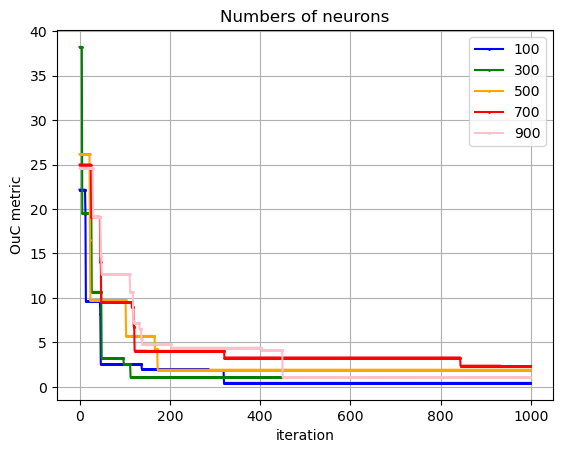

In [16]:
# Plot each dataset with labels
plt.plot(L_epsilon_N100, marker='o', linestyle='-', color='blue', label='100', markersize=1)
plt.plot(L_epsilon_N300, marker='o', linestyle='-', color='green', label='300', markersize=1)
plt.plot(L_epsilon_N500, marker='o', linestyle='-', color='orange', label='500', markersize=1)
plt.plot(L_epsilon_N700, marker='o', linestyle='-', color='red', label='700', markersize=1)
plt.plot(L_epsilon_N900, marker='o', linestyle='-', color='pink', label='900', markersize=1)

# Add labels, title, legend and grid
plt.xlabel('iteration')
plt.ylabel('OuC metric')
plt.title('Numbers of neurons')
plt.legend()  # Show the legend to distinguish the datasets
plt.grid(True)
plt.show()


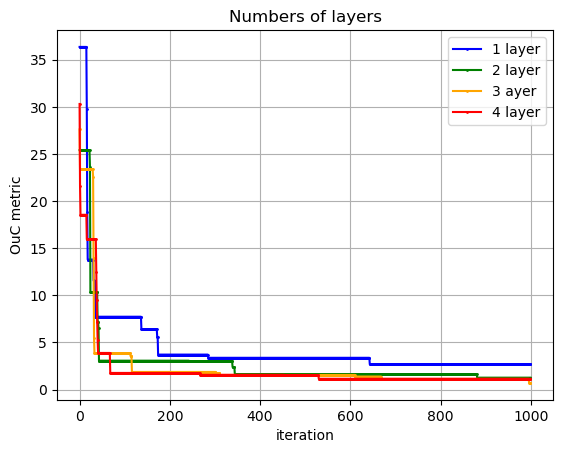

In [14]:
# Plot each dataset with labels
plt.plot(L_epsilon_N100, marker='o', linestyle='-', color='blue', label='1 layer', markersize=1)
plt.plot(L_epsilon_N300, marker='o', linestyle='-', color='green', label='2 layer', markersize=1)
plt.plot(L_epsilon_N500, marker='o', linestyle='-', color='orange', label='3 ayer', markersize=1)
plt.plot(L_epsilon_N700, marker='o', linestyle='-', color='red', label='4 layer', markersize=1)

# Add labels, title, legend and grid
plt.xlabel('iteration')
plt.ylabel('OuC metric')
plt.title('Numbers of layers')
plt.legend()  # Show the legend to distinguish the datasets
plt.grid(True)
plt.show()


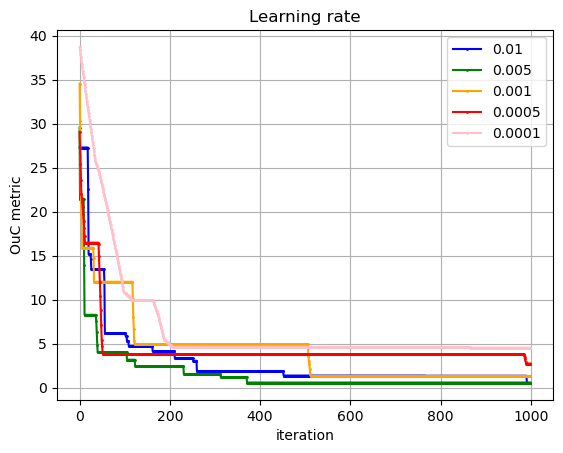

In [15]:
# Plot each dataset with labels
plt.plot(L_epsilon_N100, marker='o', linestyle='-', color='blue', label='0.01', markersize=1)
plt.plot(L_epsilon_N300, marker='o', linestyle='-', color='green', label='0.005', markersize=1)
plt.plot(L_epsilon_N500, marker='o', linestyle='-', color='orange', label='0.001', markersize=1)
plt.plot(L_epsilon_N700, marker='o', linestyle='-', color='red', label='0.0005', markersize=1)
plt.plot(L_epsilon_N900, marker='o', linestyle='-', color='pink', label='0.0001', markersize=1)

# Add labels, title, legend and grid
plt.xlabel('iteration')
plt.ylabel('OuC metric')
plt.title('Learning rate')
plt.legend()  # Show the legend to distinguish the datasets
plt.grid(True)
plt.show()

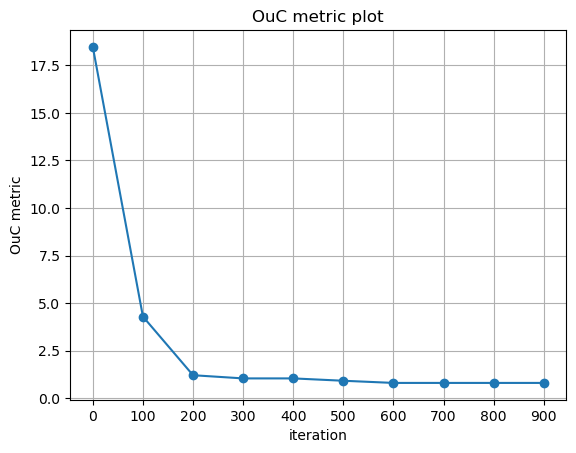

In [17]:
interval = 100
# Automatically calculate indices to plot
indices_to_plot = [i for i in range(0, len(L_epsilon), interval)]
# Extract corresponding y_values
y_values = [L_epsilon[i] for i in indices_to_plot]

plt.plot(indices_to_plot, y_values, marker='o', linestyle='-')
plt.xlabel('iteration')
plt.ylabel('OuC metric')
plt.title('OuC metric plot')
plt.xticks(indices_to_plot)  # Set x-axis ticks to the specific indices
plt.grid(True)
plt.show()

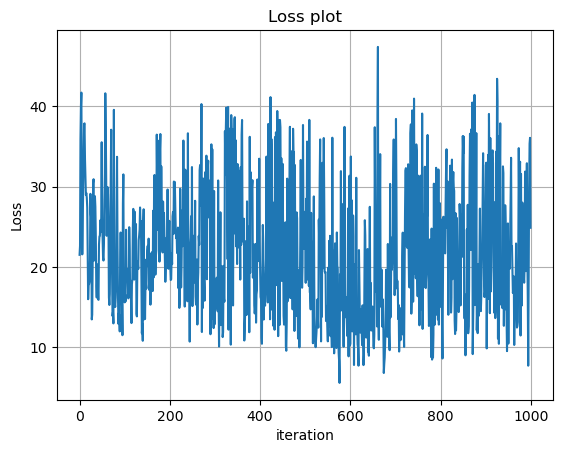

In [18]:
# Loss plot
plt.plot(L_loss, linestyle='-')  # Plot the values with markers and lines
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.title('Loss plot')
plt.grid(True)  # Add a grid for better readability
plt.show()  # Display the plot

In [19]:
t_span = [0, 10]
t_eval = np.linspace(t_span[0], t_span[1], 100)
sol = solve_ivp(ODE, [0, 10], y0, method=NUMERICAL_METHOD, t_eval=t_eval)
y_ODE = sol.y


In [20]:
t_torch = torch.tensor(t_eval.reshape((-1, 1)), dtype=torch.float).cuda()

y_nn = net_best(t_torch)
y_nn = y_nn.T.cpu().detach().numpy()

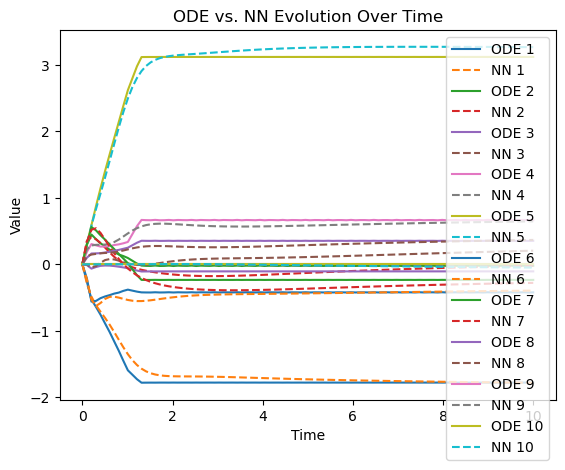

In [21]:
# Create a figure and axes
fig, ax = plt.subplots()

# Iterate and plot
for i in range(y_ODE.shape[0]):
    ax.plot(t_eval, y_ODE[i], label=f'ODE {i+1}')  # Adjust label as needed
    ax.plot(t_eval, y_nn[i], label=f'NN {i+1}', linestyle='--')  # Adjust label and style

# Add labels, legend, and title
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title('ODE vs. NN Evolution Over Time')
ax.legend()

# Display the plot
plt.show()